In [1]:
from __future__ import print_function
from __future__ import division 
import numpy as np
import xarray as xr
import os
from mpl_toolkits.basemap import Basemap
import proplot as plot
import netCDF4
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_latlon_with_map(ax, dt, cmap='RdBu_r', cnlevels=None,
            extend='neither', add_cbar=True, 
            cbar_loc='bottom', cbar_pad=0.3, title=None): 
    """
    Plot the single lat/lon map in ax.
    """
    lats = dt.lat.values
    lons = dt.lon.values
    lons_2d, lats_2d = np.meshgrid(lons, lats)
    m = Basemap(lon_0=180, ax=ax, resolution='c')
    m.drawcoastlines()
    m.drawparallels(np.arange(-60.,61.,30.),   labels=[1,0,0,0], linewidth=0, fontsize=10)
    m.drawmeridians(np.arange(-180.,181.,60.), labels=[0,0,0,1], linewidth=0, fontsize=10)
    xi, yi = m(lons_2d, lats_2d)
    if cnlevels is None:
        cs = m.contourf(xi, yi, dt, cmap=cmap)
    else:
        cs = m.contourf(xi, yi, dt, cmap=cmap, levels=cnlevels, extend=extend)
    if add_cbar:
        m.colorbar(cs, location=cbar_loc, pad=cbar_pad) # cbar
    ax.set_title(title, loc='left')

    return cs


def plot_multiple_latlon_maps(dt_arr, title_arr, nrows=2, ncols=3,
        units_arr=None, units=None, cmap_arr=None, cmap=None,
        cnlevels_arr=None, cnlevels=None, extend_arr=None, extend=None, 
        width=5, height=3.5, title_add_gm=False, fig_name=None, axwidth=4, suptitle=None):
    """
    Plot multiple lat/lon maps.
    """
    import string

    plot.close()
    fig, axes = plot.subplots(nrows=nrows, ncols=ncols,  axwidth=axwidth) 

    for kk, (ax, dt, title) in enumerate(zip(axes, dt_arr, title_arr)):
        # Determine the cmap, cnlevels and extend
        if cmap_arr is not None:
            i_cmap = cmap_arr[kk]
        else:
            if cmap is None:
                print('cmap should not be None if cmap_arr is None.')
            else:
                i_cmap = cmap

        if cnlevels_arr is not None:
            i_cnlevels = cnlevels_arr[kk]
        else:
            i_cnlevels = cnlevels

        if extend_arr is not None:
            i_extend = extend_arr[kk]
        else:
            if extend is None:
                print('extend should not be None if extend_arr is None.')
            else:
                i_extend = extend
        
        if units_arr is not None:
            i_units = units_arr[kk]
        else:
            if units is None:
                print('units should not be None if units_arr is None.')
            else:
                i_units = units

        # Prepare the title string
        prefix = '('+string.ascii_lowercase[kk]+') '+title
        if title_add_gm:
            coslat = np.cos(np.deg2rad(dt.lat))
            dt_gm = np.average(dt.mean('lon'), axis=0, weights=coslat)
            val_str = ' (%.2f'%(dt_gm) + i_units + ')'
        else:
            val_str = ''
        i_title = prefix + val_str
        
        # call func to plot single map
        cs = plot_latlon_with_map(ax, dt, cmap=i_cmap, cnlevels= i_cnlevels, 
                extend=i_extend, title=i_title, add_cbar=False)
    if suptitle is not None:
        axes.format(suptitle=suptitle)
    fig.colorbar(cs, loc='b', length=0.8, width='0.8em', label='Cloud fraction (%)')

    fig.tight_layout()
    fig.savefig(fig_name, bbox_inches='tight', pad_inches=0.05, transparent=False)
    fig.savefig(fig_name.replace('.pdf', '.png'), bbox_inches='tight', pad_inches=0.05, transparent=False)

In [3]:
def sundqvist_diag(ds, rh_crit=0.7):
    """ cf = 1 - sqrt((1-rh)/(1-rh_crit))"""
    
    rh = ds.r
    cf = np.zeros_like(rh)

    rh1 = rh / 1e2
    rh2 = np.where(rh1<1, rh1, 1.0)

    cf = np.where( rh2<rh_crit, 0, 1.0 - np.sqrt( (1 - rh2) / (1 - rh_crit) ) )

    ds['cf_sundqvist_'+str(rh_crit)] = (rh.dims, cf)


def linear_diag11(ds):
    """cf = a * (rh - 1) + 1"""
    
    a_surf = 42
    a_top = 13

    nx = 11
    ps = 1e3

    coeff_a_fit = a_top + (a_surf-a_top)*np.exp(1.0 - (ps/levels)**nx)

    rh = ds.r / 1e2

    cf = (rh-1) * coeff_a_fit + 1
    cf = np.where(cf<0, 0, cf)
    cf = np.where(cf>1, 1, cf)

    ds['cf_linear11'] = (rh.dims, cf)


def linear_diag(ds):
    """cf = a * rh + b"""

    levels = ds.level

    # Read coeff_a and coeff_b from data...
    fn = './data/fit_linear_para_ab_201701_T42_90S_90N.nc'
    if not os.path.exists(fn):
        # Need to run the following scripts to get data
        os.system('python get_linear_coeffs_a_b.py')

    ds_para = xr.open_dataset(fn, decode_times=False)
    coeff_a = ds_para.para_ab[:,:,0].mean('time')
    coeff_b = ds_para.para_ab[:,:,1].mean('time')

    rh = ds.r / 1e2
    #cf = rh *coeff_a_fit + coeff_b_fit
    cf = rh *coeff_a + coeff_b
    cf = np.where(cf<0, 0, cf)
    cf = np.where(cf>1, 1, cf)

    ds['cf_linear'] = (rh.dims, cf)

Diag from Sundqvist scheme...
Diag from linear RH schemes...
Plot comparison figure...
20 450.0


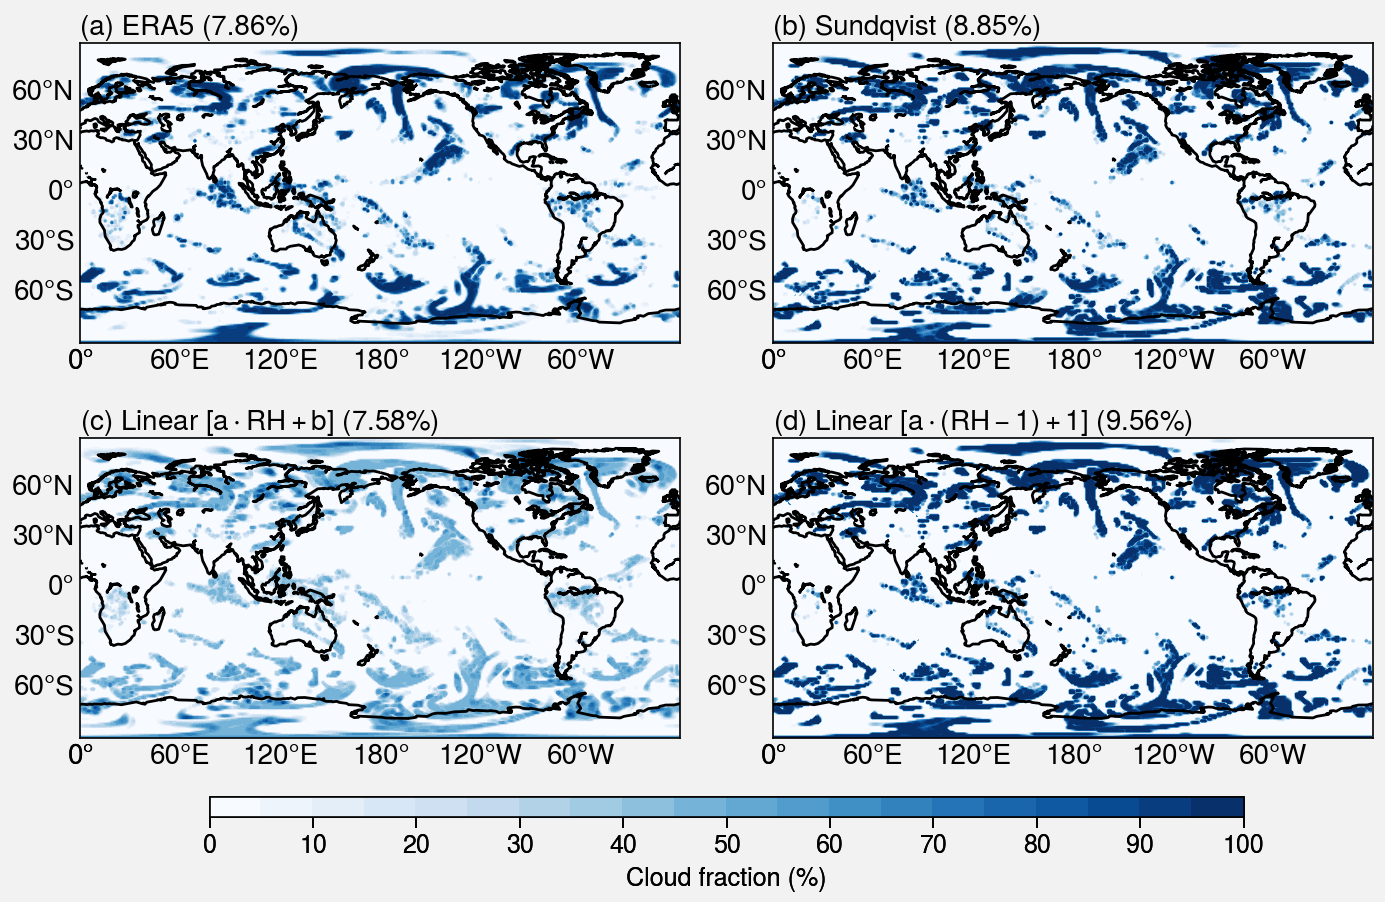

In [4]:
P=os.path.join

fig_dir = '../figs'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

fn = '/scratch/ql260/obs_datasets/era5/cld_rh_sphum_cldwater_2017_Jan_01_hour_01_12_1x1.nc'
ds = xr.open_dataset(fn, decode_times=False)

time = ds.time
dates = netCDF4.num2date(time, time.units, time.calendar)

cc = ds.cc
levels = ds.level

# For Sundqvist scheme
print('Diag from Sundqvist scheme...')
for rh_crit in [0.9]: # [0.6, 0.7, 0.8, 0.9]
    # print(rh_crit)
    sundqvist_diag(ds, rh_crit=rh_crit)

rh_crit = 0.9
cf_nm = 'cf_sundqvist_' + str(rh_crit)

# For linear schemes
print('Diag from linear RH schemes...')
linear_diag11(ds)
linear_diag(ds)

# Select time and level to plot
lev_id_arr = [20]  # [30, 20, 10, 5]
time_id_arr = [12] #, 5

print('Plot comparison figure...')
for lev_id in lev_id_arr:
    print(lev_id, levels[lev_id].values)
    for time_id in time_id_arr:
        nm_str = '_t_'+str(time_id)+'_lev_'+str(lev_id)
        fig_name = P(fig_dir, 'cmp_sundqvist_linear_with_era5_cc_a_b_read_from_profile'+ nm_str+ '.pdf')
        dt_arr = [ cc[time_id, lev_id, :, :], ds[cf_nm][time_id, lev_id, :, :],
                ds['cf_linear'][time_id, lev_id, :, :],  ds['cf_linear11'][time_id, lev_id, :, :] ]
        dt_arr = [dt * 1e2 for dt in dt_arr]

        title_arr = ['ERA5', 'Sundqvist', 'Linear [$a\cdot RH+b$]', 'Linear [$a\cdot(RH-1)+1$]']
        plot_multiple_latlon_maps(dt_arr, title_arr, nrows=2, ncols=2, units='%', 
                    title_add_gm=True, fig_name=fig_name, cmap='Blues', extend='neither',
                    cnlevels=np.arange(0,101,5), axwidth=3.)